# Technical Paper: Implementation of Sarcasm Detection using LSTM & Word Embeddings

In [17]:
# Import relevant modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import tensorflow as tf
import string
import re

from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

plt.style.use('seaborn')
nltk.download('punkt')
print("Tensorflow version: ", tf.__version__)

[nltk_data] Downloading package punkt to /Users/angks/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

Tensorflow version:  2.6.0


In [2]:
# Load dataset

dataset = pd.read_json("./dataset/Sarcasm_Headlines_Dataset_v2.json", lines=True)
dataset.head()

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


## EDA

In [3]:
# understanding the shape of 
dataset.shape

(28619, 3)

In [4]:
# Check for null values

dataset.isnull().sum()

is_sarcastic    0
headline        0
article_link    0
dtype: int64

In [5]:
dataset.describe(include="object")

,headline,article_link
count,28619,28619
unique,28503,28617
top,"'no way to prevent this,' says only nation whe...",https://politics.theonion.com/nation-not-sure-...
freq,12,2


In [6]:
# Get nummber of duplicates

print(f"Duplicated values: {len(dataset[dataset.headline.duplicated()])}")

Duplicated values: 116


The dataset contains 116 duplicated headlines.

In [7]:
# Check if the labels of the duplicated headlines are different
count_of_target = 0
for target in dataset.groupby(dataset.headline).is_sarcastic.agg(list):
    if(len(set(list(target))) != 1):
        count_of_target += 1
print(count_of_target)

0


<Figure size 720x360 with 0 Axes>

/Users/angks/opt/miniconda3/envs/tf2.6/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='is_sarcastic', ylabel='count'>

Text(0.5, 1.0, 'Distribution of the labels')

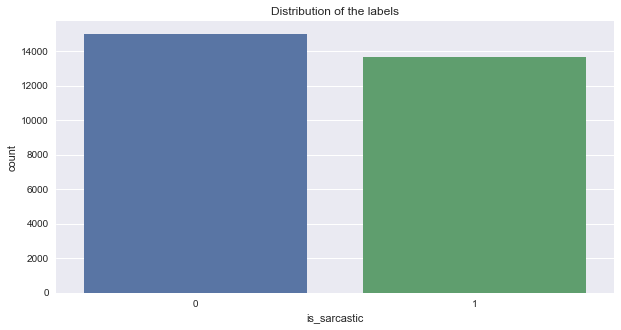

In [8]:
# Plot distribution of the labels
plt.figure(figsize=(10,5))
sns.countplot(dataset.is_sarcastic)
plt.title("Distribution of the labels")
plt.show()


<Figure size 720x504 with 0 Axes>

Text(0.5, 1.0, 'Common Keywords used for Sarcasm')

(-0.5, 1919.5, 1079.5, -0.5)

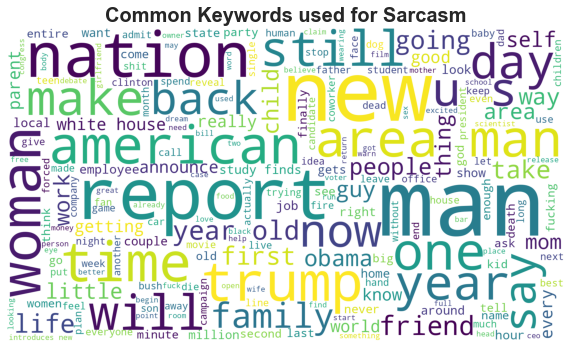

In [9]:
# Get common keywords from Sarcastic headlines

all_keywords = " ".join(line for line in dataset[dataset.is_sarcastic == 1].headline)

word_cloud = WordCloud(width=1920, height=1080, random_state=21, max_font_size=320, background_color='white').generate(all_keywords)

plt.figure(figsize=(10,7))
plt.imshow(word_cloud)
plt.title("Common Keywords used for Sarcasm", size=20, weight='bold')
plt.axis("off")
plt.show()


Text(0.5, 1.0, 'Common Keywords used for Non-Sarcasm')

(-0.5, 1919.5, 1079.5, -0.5)

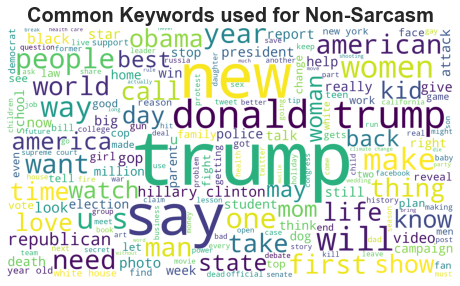

In [10]:
# Keywords used for Non-Sarcasstic headlines
all_keywords = " ".join(line for line in dataset[dataset.is_sarcastic == 0].headline)

word_cloud = WordCloud(width=1920, height=1080, random_state=21, max_font_size=320, background_color='white').generate(all_keywords)
plt.title("Common Keywords used for Non-Sarcasm", size=20, weight='bold')
plt.imshow(word_cloud)
plt.axis("off")
plt.show()


## Data Cleansing

In [13]:
# Cleaning headlines with stopwords

def clean_headlines(headline):
    STOPWORDS = set(stopwords.words('english'))
    headline = headline.lower()
    headline = " ".join([word for word in headline.split() if word not in STOPWORDS])
    headline = "".join(word for word in headline if word not in set(string.punctuation))
    return headline

dataset.headline = dataset.headline.apply(clean_headlines)
dataset.drop('article_link', inplace=True, axis=1) # Remove the article source link
dataset.head()

,is_sarcastic,headline
0,1,thirtysomething scientists unveil doomsday clo...
1,0,dem rep totally nails congress falling short g...
2,0,eat veggies 9 deliciously different recipes
3,1,inclement weather prevents liar getting work
4,1,mother comes pretty close using word streaming...


## Data Pre-Processing

In [18]:
corpus = []
for text in dataset.headline:
    words = [word.lower() for word in word_tokenize(text)]
    corpus.append(words)
num_words = len(corpus)
print(num_words)

28619


In [19]:
# train test split

X = dataset.headline.values
y = dataset.is_sarcastic.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21)


In [20]:
# Tokenize the words and add paddings for equal dimensions

max_len = 32
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

X_train = pad_sequences(X_train, maxlen=max_len, truncating='post', padding='post')
X_test = pad_sequences(X_test, maxlen=max_len, truncating='post', padding='post')

In [21]:
word_index = tokenizer.word_index
print(f"Number of unique words: {len(word_index)}")

Number of unique words: 26563


In [22]:
# get shape of the data
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")



Shape of X_train: (22895, 32)
Shape of X_test: (5724, 32)
Shape of y_train: (22895,)
Shape of y_test: (5724,)


In [26]:
# Model 01: Simple RNN

simpleRNN = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=num_words, output_dim=100, input_length=max_len),
    tf.keras.layers.SimpleRNN(64, dropout=0.2, recurrent_dropout=0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
simpleRNN.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

2021-11-04 13:41:59.954398: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [27]:
simpleRNN.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 32, 100)           2861900   
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 64)                10560     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 2,872,525
Trainable params: 2,872,525
Non-trainable params: 0
_________________________________________________________________


In [28]:
# Fit SimpleRNN model

simpleRNN_result = simpleRNN.fit(X_train, y_train, epochs=20, batch_size=1024, validation_data=(X_test, y_test))

2021-11-04 13:42:59.967900: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20
23/23 [==============================] - 5s 140ms/step - loss: 0.7079 - accuracy: 0.5091 - val_loss: 0.6913 - val_accuracy: 0.5178
Epoch 2/20
23/23 [==============================] - 3s 137ms/step - loss: 0.6977 - accuracy: 0.5131 - val_loss: 0.6904 - val_accuracy: 0.5180
Epoch 3/20
23/23 [==============================] - 3s 152ms/step - loss: 0.6952 - accuracy: 0.5131 - val_loss: 0.6861 - val_accuracy: 0.5454
Epoch 4/20
23/23 [==============================] - 5s 200ms/step - loss: 0.6874 - accuracy: 0.5483 - val_loss: 0.6393 - val_accuracy: 0.6618
Epoch 5/20
23/23 [==============================] - 7s 317ms/step - loss: 0.6302 - accuracy: 0.6818 - val_loss: 0.6244 - val_accuracy: 0.6848
Epoch 6/20
23/23 [==============================] - 11s 488ms/step - loss: 0.6003 - accuracy: 0.7173 - val_loss: 0.6504 - val_accuracy: 0.6492
Epoch 7/20
23/23 [==============================] - 9s 407ms/step - loss: 0.6528 - accuracy: 0.6339 - val_loss: 0.6653 - val_accuracy: 0.6003
Epoch

In [29]:
def plotLossAccGraph(result):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    ax1.plot(result.history['loss'], label='Training Loss')
    ax1.plot(result.history['val_loss'], label='Validation Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    # ax1.set_ylim(bottom=0.0, top=0.6)
    ax1.legend()

    ax2.plot(result.history['accuracy'], label='Training Accuracy')
    ax2.plot(result.history['val_accuracy'], label='Validation Accuracy')
    ax2.set_title('Training and Validation Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    # ax2.set_ylim(bottom=0.85, top=1.0)
    ax2.legend()

    plt.show()


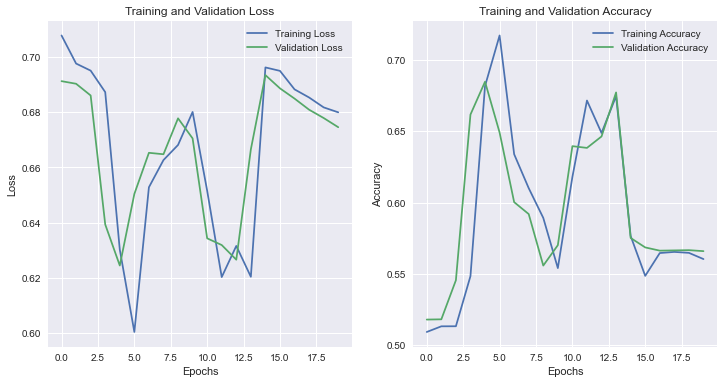

In [30]:
plotLossAccGraph(simpleRNN_result)